In [1]:
import numpy as np
import scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import functional_sensitivity_lib as fun_sens_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

np.random.seed(453453)



# Load data

In [2]:
# load iris dataset 

from sklearn import datasets

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]
iris_species = iris[1]

dim = iris_features.shape[1]

# Set prior params

In [3]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [4]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [5]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [6]:
# print(model.vb_params)

# Set inits

In [7]:
n_kmeans_init = 10
init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [8]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()

# Optimize!

In [9]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=100,
    final_max_iter=500)
t_newton = time.time() - t0


Iter: 0	 RMSE: 5.542288625883365	 Objective: 5610.49484202776
Iter: 10	 RMSE: 9.605433006405969	 Objective: 3699.6999716194764
Iter: 20	 RMSE: 10.728858038655394	 Objective: 1620.8361392473348
Iter: 30	 RMSE: 9.731621277938128	 Objective: 147.13206312763612
Iter: 40	 RMSE: 9.381685017909854	 Objective: -88.7633466199066
Iter: 50	 RMSE: 9.278433846022235	 Objective: -218.9999328819035
Iter: 60	 RMSE: 9.224364732514404	 Objective: -263.066867945217
Iter: 70	 RMSE: 9.183707357680204	 Objective: -275.3955956678366
Iter: 80	 RMSE: 9.217833940865729	 Objective: -283.721887875261
Iter: 90	 RMSE: 9.159710030564899	 Objective: -288.44087676881065
Iter: 100	 RMSE: 9.170809163824112	 Objective: -291.3208476121377
         Current function value: -292.618810
         Iterations: 100
         Function evaluations: 107
         Gradient evaluations: 107
Iter: 110	 RMSE: 9.207484441365306	 Objective: -298.07271557631475
Optimization terminated successfully.
         Current function value: -299.47430

In [10]:
newton_results = deepcopy(model)

# Get sensitivity operators

In [11]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [12]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)


In [13]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


(0.09999999999989616+0j) (2452.4205477400733+0j)


In [14]:
# Check my manually implemented jacobian: 

In [15]:
x = np.linspace(0.01, 0.99, 100)
get_true_log_q_pi_jac = autograd.jacobian(linear_sens.get_log_q_pi, 0)

In [16]:
for k in range(k_approx - 1): 
    my_jac = linear_sens.log_q_pi_jac(linear_sens.optimal_global_free_params, x, k = k)
    true_jac = get_true_log_q_pi_jac(linear_sens.optimal_global_free_params, x, k = k)
    assert np.max(np.abs(my_jac - true_jac)) < 1e-12

# Functional Sensitivty

In [17]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

get_g_eta = autograd.jacobian(get_stick_length_from_free_param, argnum = 1)
g_eta = get_g_eta(model, best_param)


In [18]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx - 1, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


In [19]:
total_influence_sticks2 = np.dot(g_eta, linear_sens.total_influence_function(theta))

In [20]:
np.max(np.abs(total_influence_sticks - total_influence_sticks2)) 

2.7284841053187847e-12

In [21]:
assert np.max(np.abs(total_influence_sticks - total_influence_sticks2)) < 1e-8

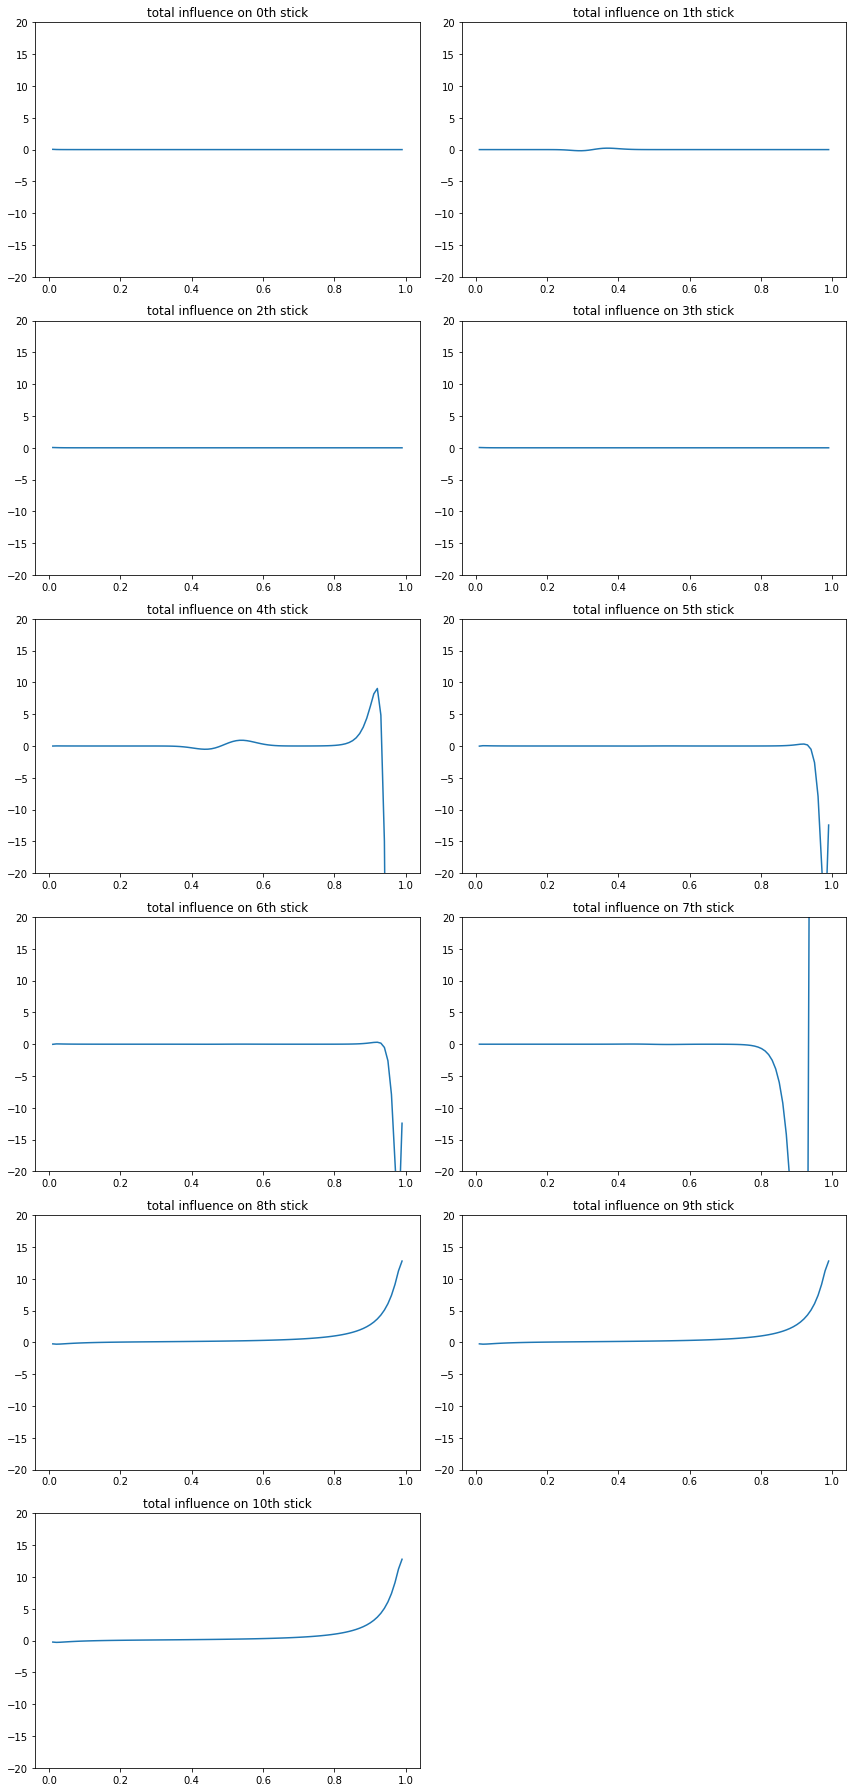

In [21]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-20.0, 20.0])
    axarr[indx1, indx2].set_title('total influence on {}th stick'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


In [22]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [23]:
# we examine the influence on the posterior stick lengths
def get_centroid_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return model.global_vb_params['centroids'].get().T.flatten()

get_g_eta_for_centroids= autograd.jacobian(get_centroid_from_free_param, argnum = 1)
g_eta_for_centroids = get_g_eta_for_centroids(model, best_param)


In [24]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_centroids = np.zeros((np.shape(g_eta_for_centroids)[0], len(theta)))
for k in range(k_approx - 1): 
    total_influence_centroids += np.dot(g_eta_for_centroids, linear_sens.influence_function(theta, k))


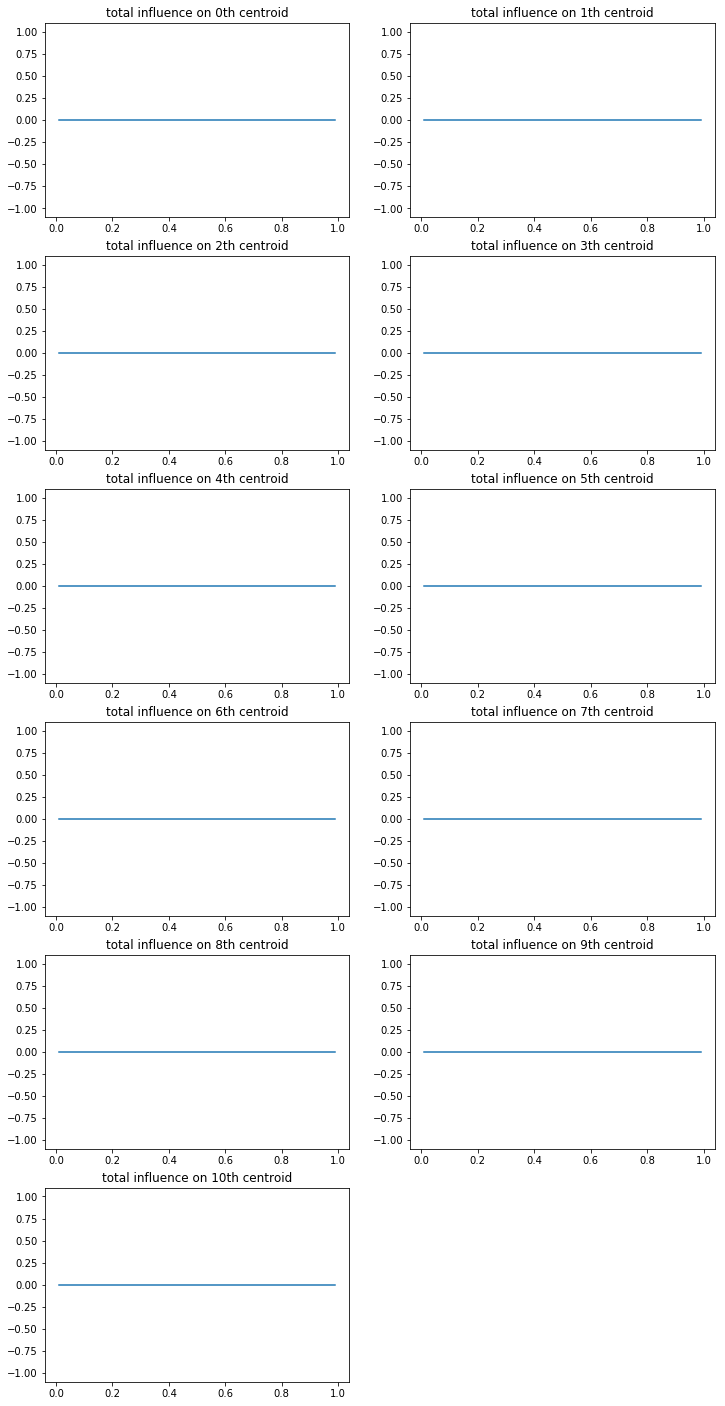

In [25]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_centroids[k, :])
    axarr[indx1, indx2].set_ylim([-1.1, 1.1])
    axarr[indx1, indx2].set_title('total influence on {}th centroid'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])



In [26]:
u = lambda x : 1.0 - x

In [27]:
# this is E_q(u(x) / p_0(x))
gh_integration = linear_sens.influence_integration(linear_sens.optimal_global_free_params, u)

In [28]:
gh_integration

array([ 0.25331254,  0.56071247,  0.25495298,  0.25495298,  0.95639595,
        0.25973011,  0.25973011, 98.67130548,  0.59060873,  0.59060873,
        0.59060873])

In [29]:
n_grid = 10000000
x = np.linspace(0.01, 0.99, n_grid)


In [30]:
alpha = model.prior_params['alpha'].get()
integrand = np.zeros((k_approx - 1, n_grid))
for k in tqdm(range(k_approx - 1)): 
    # influence_density_logratio is u(x) / p_0(x)
    # get_log_q_pi returns the variational density
    integrand[k, :] = np.exp(linear_sens.get_log_q_pi(best_param, x, k) + 
        linear_sens.influence_density_logratio(x, alpha, u))


100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


In [31]:
grid_integration = np.mean(integrand, axis = 1)
grid_integration

array([4.66549992e-02, 5.72155526e-01, 7.87160384e-02, 7.87160384e-02,
       9.75914133e-01, 1.46702946e-01, 1.46702946e-01, 1.00280604e+02,
       5.99196184e-01, 5.99196184e-01, 5.99196184e-01])

In [32]:
sp_integration = np.zeros(k_approx - 1)
for k in tqdm(range(k_approx - 1)):
    fun_integrand = lambda x : np.exp(linear_sens.get_log_q_pi(best_param, x, k) + 
        linear_sens.influence_density_logratio(x, alpha, u))
    
    sp_integration[k] = sp.integrate.quad(fun_integrand, 0, 1)[0]


100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


In [33]:
sp_integration

array([ 0.25331254,  0.56071247,  0.25495298,  0.25495298,  0.95639595,
        0.25973013,  0.25973013, 98.67130576,  0.59073378,  0.59073378,
        0.59073378])

In [34]:
# importance sampling

imp_sampling_integration = np.zeros(k_approx - 1)
n_samples = int(1e6)

for k in tqdm(range(k_approx - 1)):

    mean = newton_results.vb_params['global']['v_sticks']['mean'].get()[k]
    info = newton_results.vb_params['global']['v_sticks']['info'].get()[k]
    
    # sample from variational distribution with twice the standard deviation
    x = np.random.normal(mean, 1/np.sqrt(0.5 * info), size = n_samples)
    x = sp.special.expit(x)

    # divide the integrand by the density of the variational distribution 
    # with twice the standard deviation
    log_integrand = linear_sens.influence_density_logratio(x, alpha, u) + \
            linear_sens.get_log_q_pi(linear_sens.optimal_global_free_params, x, k) - \
            fun_sens_lib.get_log_logitnormal_density(x, mean, 0.5 * info)
    
    imp_sampling_integration[k] = np.mean(np.exp(log_integrand))


100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


In [35]:
imp_sampling_integration

array([ 0.25320351,  0.56043452,  0.25501733,  0.25498716,  0.95660242,
        0.25971351,  0.25981455, 98.5951367 ,  0.5911673 ,  0.59060547,
        0.59103701])

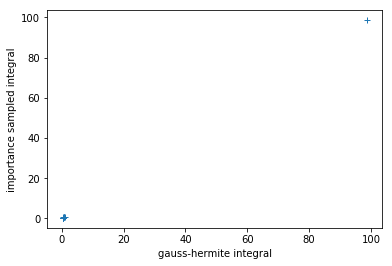

In [36]:
plt.plot(gh_integration, imp_sampling_integration, '+')
plt.xlabel('gauss-hermite integral')
plt.ylabel('importance sampled integral')


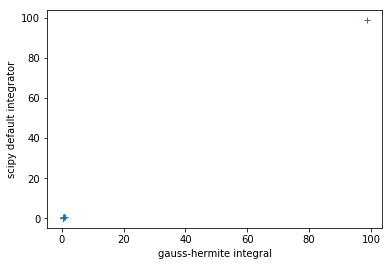

In [37]:
plt.plot(gh_integration, sp_integration, '+')
plt.xlabel('gauss-hermite integral')
plt.ylabel('scipy default integrator')


In [38]:
np.max(np.abs((gh_integration - sp_integration) / sp_integration))

0.00021168847516938623

In [39]:
np.max(np.abs((gh_integration - imp_sampling_integration) / imp_sampling_integration))

0.0009448644242725547

# Lets look at the worst case functional integration

In [22]:
import common_modeling_lib

In [23]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return common_modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [24]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

In [25]:
total_influnce_nclust = np.dot(g_eta_nclust, linear_sens.total_influence_function(theta))

In [26]:
alpha = prior_params['alpha'].get()

In [ ]:
integrand1 = lambda x : np.maximum(np.dot(g_eta_nclust, linear_sens.total_influence_function(x)), 0) ** 2 * \
           sp.stats.beta.pdf(x, 1, alpha)


integrand2 = lambda x : np.maximum(-np.dot(g_eta_nclust, linear_sens.total_influence_function(x)), 0) ** 2 * \
           sp.stats.beta.pdf(x, 1, alpha)

wc_sp_integration1 = sp.integrate.quad(integrand1, 0, 1)
wc_sp_integration2 = sp.integrate.quad(integrand2, 0, 1)


In [ ]:
wc_sp_integration1

In [ ]:
wc_sp_integration2

In [ ]:
n_samples = int(1e5)

In [ ]:
np.mean(integrand1(np.random.rand(n_samples)))

In [ ]:
np.mean(integrand2(np.random.rand(n_samples)))

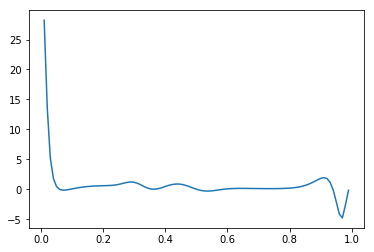

In [86]:
plt.plot(theta, total_influnce_nclust *  sp.stats.beta.pdf(theta, 1, 4))

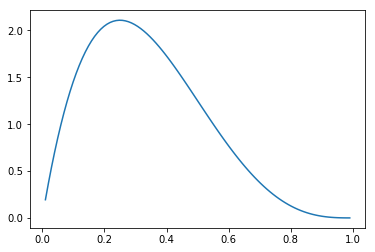

In [83]:
plt.plot(theta, sp.stats.beta.pdf(theta, 2, 4))

In [45]:
wc_sp_integration1 = np.zeros(k_approx)
wc_sp_integration2 = np.zeros(k_approx)

for k in tqdm(range(k_approx - 1)): 
    
    integrand1 = lambda x : np.maximum(np.dot(g_eta, linear_sens.total_influence_function(x)), 0)[k] ** 2 * \
        np.exp(2 * linear_sens.get_log_q_pi(linear_sens.optimal_global_free_params, x, k) - \
               sp.stats.beta.logpdf(x, 1, alpha))


    integrand2 = lambda x : np.maximum(-np.dot(g_eta, linear_sens.get_influence_operator(x, k)), 0)[k] ** 2 * \
        np.exp(2 * linear_sens.get_log_q_pi(linear_sens.optimal_global_free_params, x, k) - \
               sp.stats.beta.logpdf(x, 1, alpha))
        
    wc_sp_integration1[k] = sp.integrate.quad(integrand1, 0, 1)[0]
    wc_sp_integration2[k] = sp.integrate.quad(integrand2, 0, 1)[0]


190

In [ ]:
linear_sens.get_worse_case_influence(g_eta, k)

In [ ]:
wc_gh_integration1 = np.zeros(k_approx)
wc_gh_integration2 = np.zeros(k_approx)

for k in range(k_approx - 1): 
    wc_gh_integration1_, wc_gh_integration2_ = linear_sens.worse_case_integration(g_eta, k)
    wc_gh_integration1[k], wc_gh_integration2[k] = wc_gh_integration1_[k], wc_gh_integration2_[k]


In [ ]:
wc_sp_integration1 = np.zeros(k_approx)
wc_sp_integration2 = np.zeros(k_approx)

for k in tqdm(range(k_approx - 1)): 
    
    integrand1 = lambda x : np.maximum(np.dot(g_eta, linear_sens.get_influence_operator(x, k)), 0)[k] ** 2 * \
        np.exp(2 * linear_sens.get_log_q_pi(linear_sens.optimal_global_free_params, x, k) - \
               sp.stats.beta.logpdf(x, 1, alpha))


    integrand2 = lambda x : np.maximum(-np.dot(g_eta, linear_sens.get_influence_operator(x, k)), 0)[k] ** 2 * \
        np.exp(2 * linear_sens.get_log_q_pi(linear_sens.optimal_global_free_params, x, k) - \
               sp.stats.beta.logpdf(x, 1, alpha))
        
    wc_sp_integration1[k] = sp.integrate.quad(integrand1, 0, 1)[0]
    wc_sp_integration2[k] = sp.integrate.quad(integrand2, 0, 1)[0]


In [ ]:
wc_sp_integration2

In [ ]:
wc_gh_integration2

In [ ]:
n_samples = int(1e5)

wc_imp_integration1 = np.zeros(k_approx)
wc_imp_integration2 = np.zeros(k_approx)

for k in tqdm(range(k_approx - 1)): 
    mean = newton_results.vb_params['global']['v_sticks']['mean'].get()[k]
    info = newton_results.vb_params['global']['v_sticks']['info'].get()[k]
    
    ratio = lambda x : np.exp(2 * linear_sens.get_log_q_pi(linear_sens.optimal_global_free_params, x, k) - \
                sp.stats.beta.logpdf(x, 1, alpha) - 
                       fun_sens_lib.get_log_logitnormal_density(x, mean, 0.5 * info))
    
    inf_op_pos = lambda x : np.maximum(np.dot(g_eta, linear_sens.get_influence_operator(x, k)), 0)[k] ** 2 
    inf_op_neg = lambda x : np.maximum(-np.dot(g_eta, linear_sens.get_influence_operator(x, k)), 0)[k] ** 2 
    
    integrand1 = lambda x : inf_op_pos(x) * ratio(x)
    integrand2 = lambda x : inf_op_neg(x) * ratio(x)
    
    # sample from variational distribution 
    x = np.random.normal(mean, 1/np.sqrt(0.5 * info), size = n_samples)
    x = sp.special.expit(x)
    
    wc_imp_integration1[k] = np.mean(integrand1(x))
    wc_imp_integration2[k] = np.mean(integrand2(x))


In [ ]:
wc_imp_integration2

In [ ]:
wc_sp_integration2

In [ ]:
wc_imp_integration1

In [ ]:
wc_sp_integration1